# Initialize Notebook

## Import Packages

In [1]:
import pandas as pd
import hashlib as hl
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

C:\Users\dfsan\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\dfsan\anaconda3\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


## Load Utilities

Load common utility functions used throughout the data cleansing and transformation steps.

In [2]:
%run ./utils/utils_diagnosis.ipynb

# Load Preprocessed Data

In [3]:
visits_health_stats_by_week_df = pd.read_parquet('data/diagnosis_health_stats_hosp_by_week_01.parquet')

# Exploratory Data Analysis (EDA)

## Seasonal Decomposition

Since we are dealing with time series data--visit history and health statistic measures are all time-based--we'd like to uncover trend or seasonal features of our data that would be worthwhile to incorporate in our model. Since hospitalizations are our target variable, let's determine the impact of trend and seasonality on hospitalization rate specifically.

In [4]:
df = visits_health_stats_by_week_df
patients_weekly_df = df[['uid', 'visit_date_week_dt', 'ttl_hosp_week']].groupby('visit_date_week_dt').count().reset_index()
patients_weekly_df = patients_weekly_df[['visit_date_week_dt', 'uid']].rename(columns={'uid':'no_visits'})
hosp_weekly_df = df[['visit_date_week_dt', 'ttl_hosp_week']].groupby('visit_date_week_dt').sum().reset_index()
patients_per_hosp_weekly_df = patients_weekly_df.merge(hosp_weekly_df)
patients_per_hosp_weekly_df['hosp_rate'] = (patients_per_hosp_weekly_df.ttl_hosp_week / patients_per_hosp_weekly_df.no_visits) * 100
df = patients_per_hosp_weekly_df[['visit_date_week_dt', 'hosp_rate']]
df['visit_date_week_dt'] = pd.to_datetime(df['visit_date_week_dt']) 
df.set_index('visit_date_week_dt', inplace=True)

From the plots below, we can clearly distinguish a seasonal component to the data.  Additionally, we see that there is a downward trend for hospitalization rates roughly around mid 2019.  We will use this information to encode features for our model.

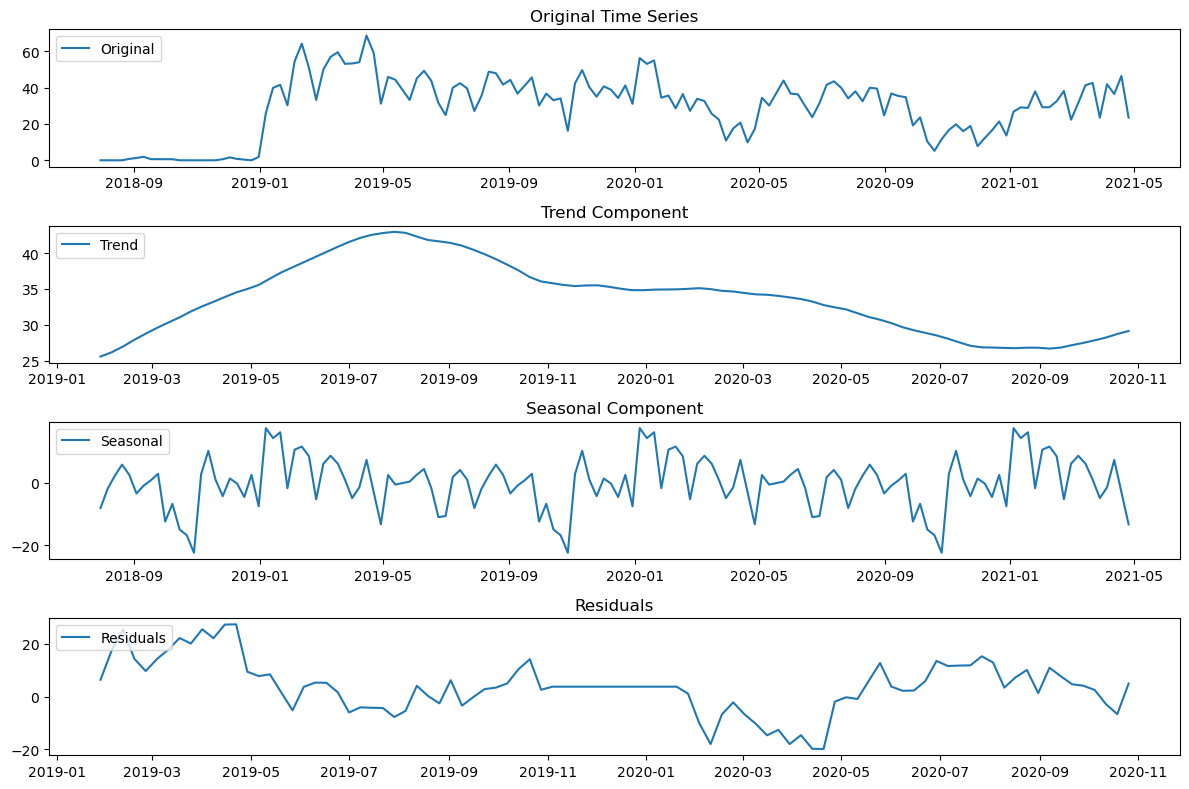

In [5]:
result = perform_seasonal_decomposition(df, 'hosp_rate', 'additive')

### Seasonal Component Feature

Let's aggregate the data further to derive our feature. We'll group the data by year and month and take the mean of the result.

<Axes: xlabel='year_month'>

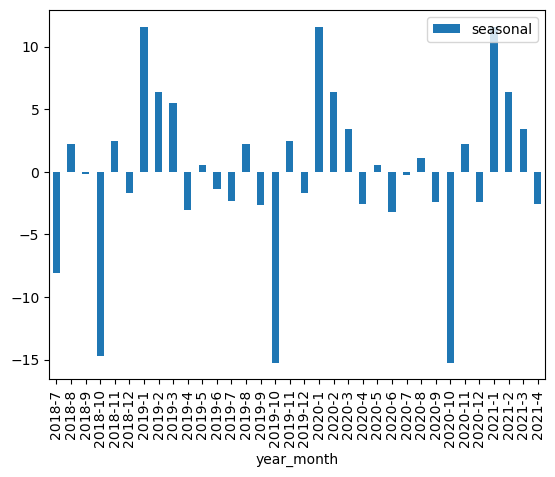

In [6]:
seasonal_df = pd.DataFrame(result['decomposition'].seasonal).reset_index()
seasonal_df['year'] = seasonal_df.visit_date_week_dt.dt.year.astype(int)
seasonal_df['month'] = seasonal_df.visit_date_week_dt.dt.month.astype(int)
seasonal_df = seasonal_df[['year', 'month', 'seasonal']].groupby(['year', 'month']).mean().reset_index()
seasonal_df = seasonal_df.sort_values(by=['year', 'month'])
seasonal_df['year_month'] = seasonal_df['year'].astype(str) +'-'+seasonal_df['month'].astype(str)
seasonal_df[['year_month', 'seasonal']].plot.bar(x='year_month', y='seasonal')

From the plot above we see that there's consistently a drop in hospitalization rate every October, a slight rise in November then a drop in December followed by a significant spike in January and then a gradual tapering off February and March.  We'll encode this information as an additional feature and add it to our training data.  We'll use 2019 as a basis. 

In [7]:
seasonal_df = seasonal_df[seasonal_df.year == 2019][['month', 'seasonal']]

### Trend Component

For trend, we observe an upward trend starting on January of 2019 and then a downward trend in the data starting in August of the same year. We then see the trend flatten out on July of 2020 and again start observing an upward trend on October of 2020.  We will hold off encoding trend as an additional feature pending the collection of more data.

<Axes: xlabel='year_month'>

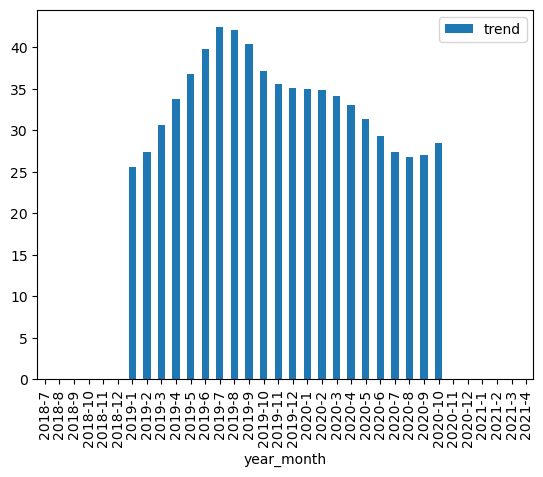

In [8]:
trend_df = pd.DataFrame(result['decomposition'].trend).reset_index()
trend_df['year'] = trend_df.visit_date_week_dt.dt.year.astype(int)
trend_df['month'] = trend_df.visit_date_week_dt.dt.month.astype(int)
trend_df = trend_df[['year', 'month', 'trend']].groupby(['year', 'month']).mean().reset_index()
trend_df = trend_df.sort_values(by=['year', 'month'])
trend_df['year_month'] = trend_df['year'].astype(str) +'-'+trend_df['month'].astype(str)
trend_df[['year_month', 'trend']].plot.bar(x='year_month', y='trend')

## Distribution of Health Stats

For this and subsequent analysis we would like to analyze a summary of health statistic values from our paient population. To do so, we take the average value of all numeric health statistics by patient and also sum the ratio of hospitalizations to visits at the patient level.  The summarize_patient_health_stats function provides us with such a summary.

In [9]:
patient_stats_df = summarize_patient_health_stats(visits_health_stats_by_week_df)

Let's plot the distribution of these values using histograms excluding the unique id (uid) and our target variable--hospitalization.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'bp_sys'}>],
       [<Axes: title={'center': 'bp_dia'}>,
        <Axes: title={'center': 'weight_lbs'}>],
       [<Axes: title={'center': 'temp_f'}>,
        <Axes: title={'center': 'pulse'}>],
       [<Axes: title={'center': 'height_val'}>,
        <Axes: title={'center': 'resp_val'}>]], dtype=object)

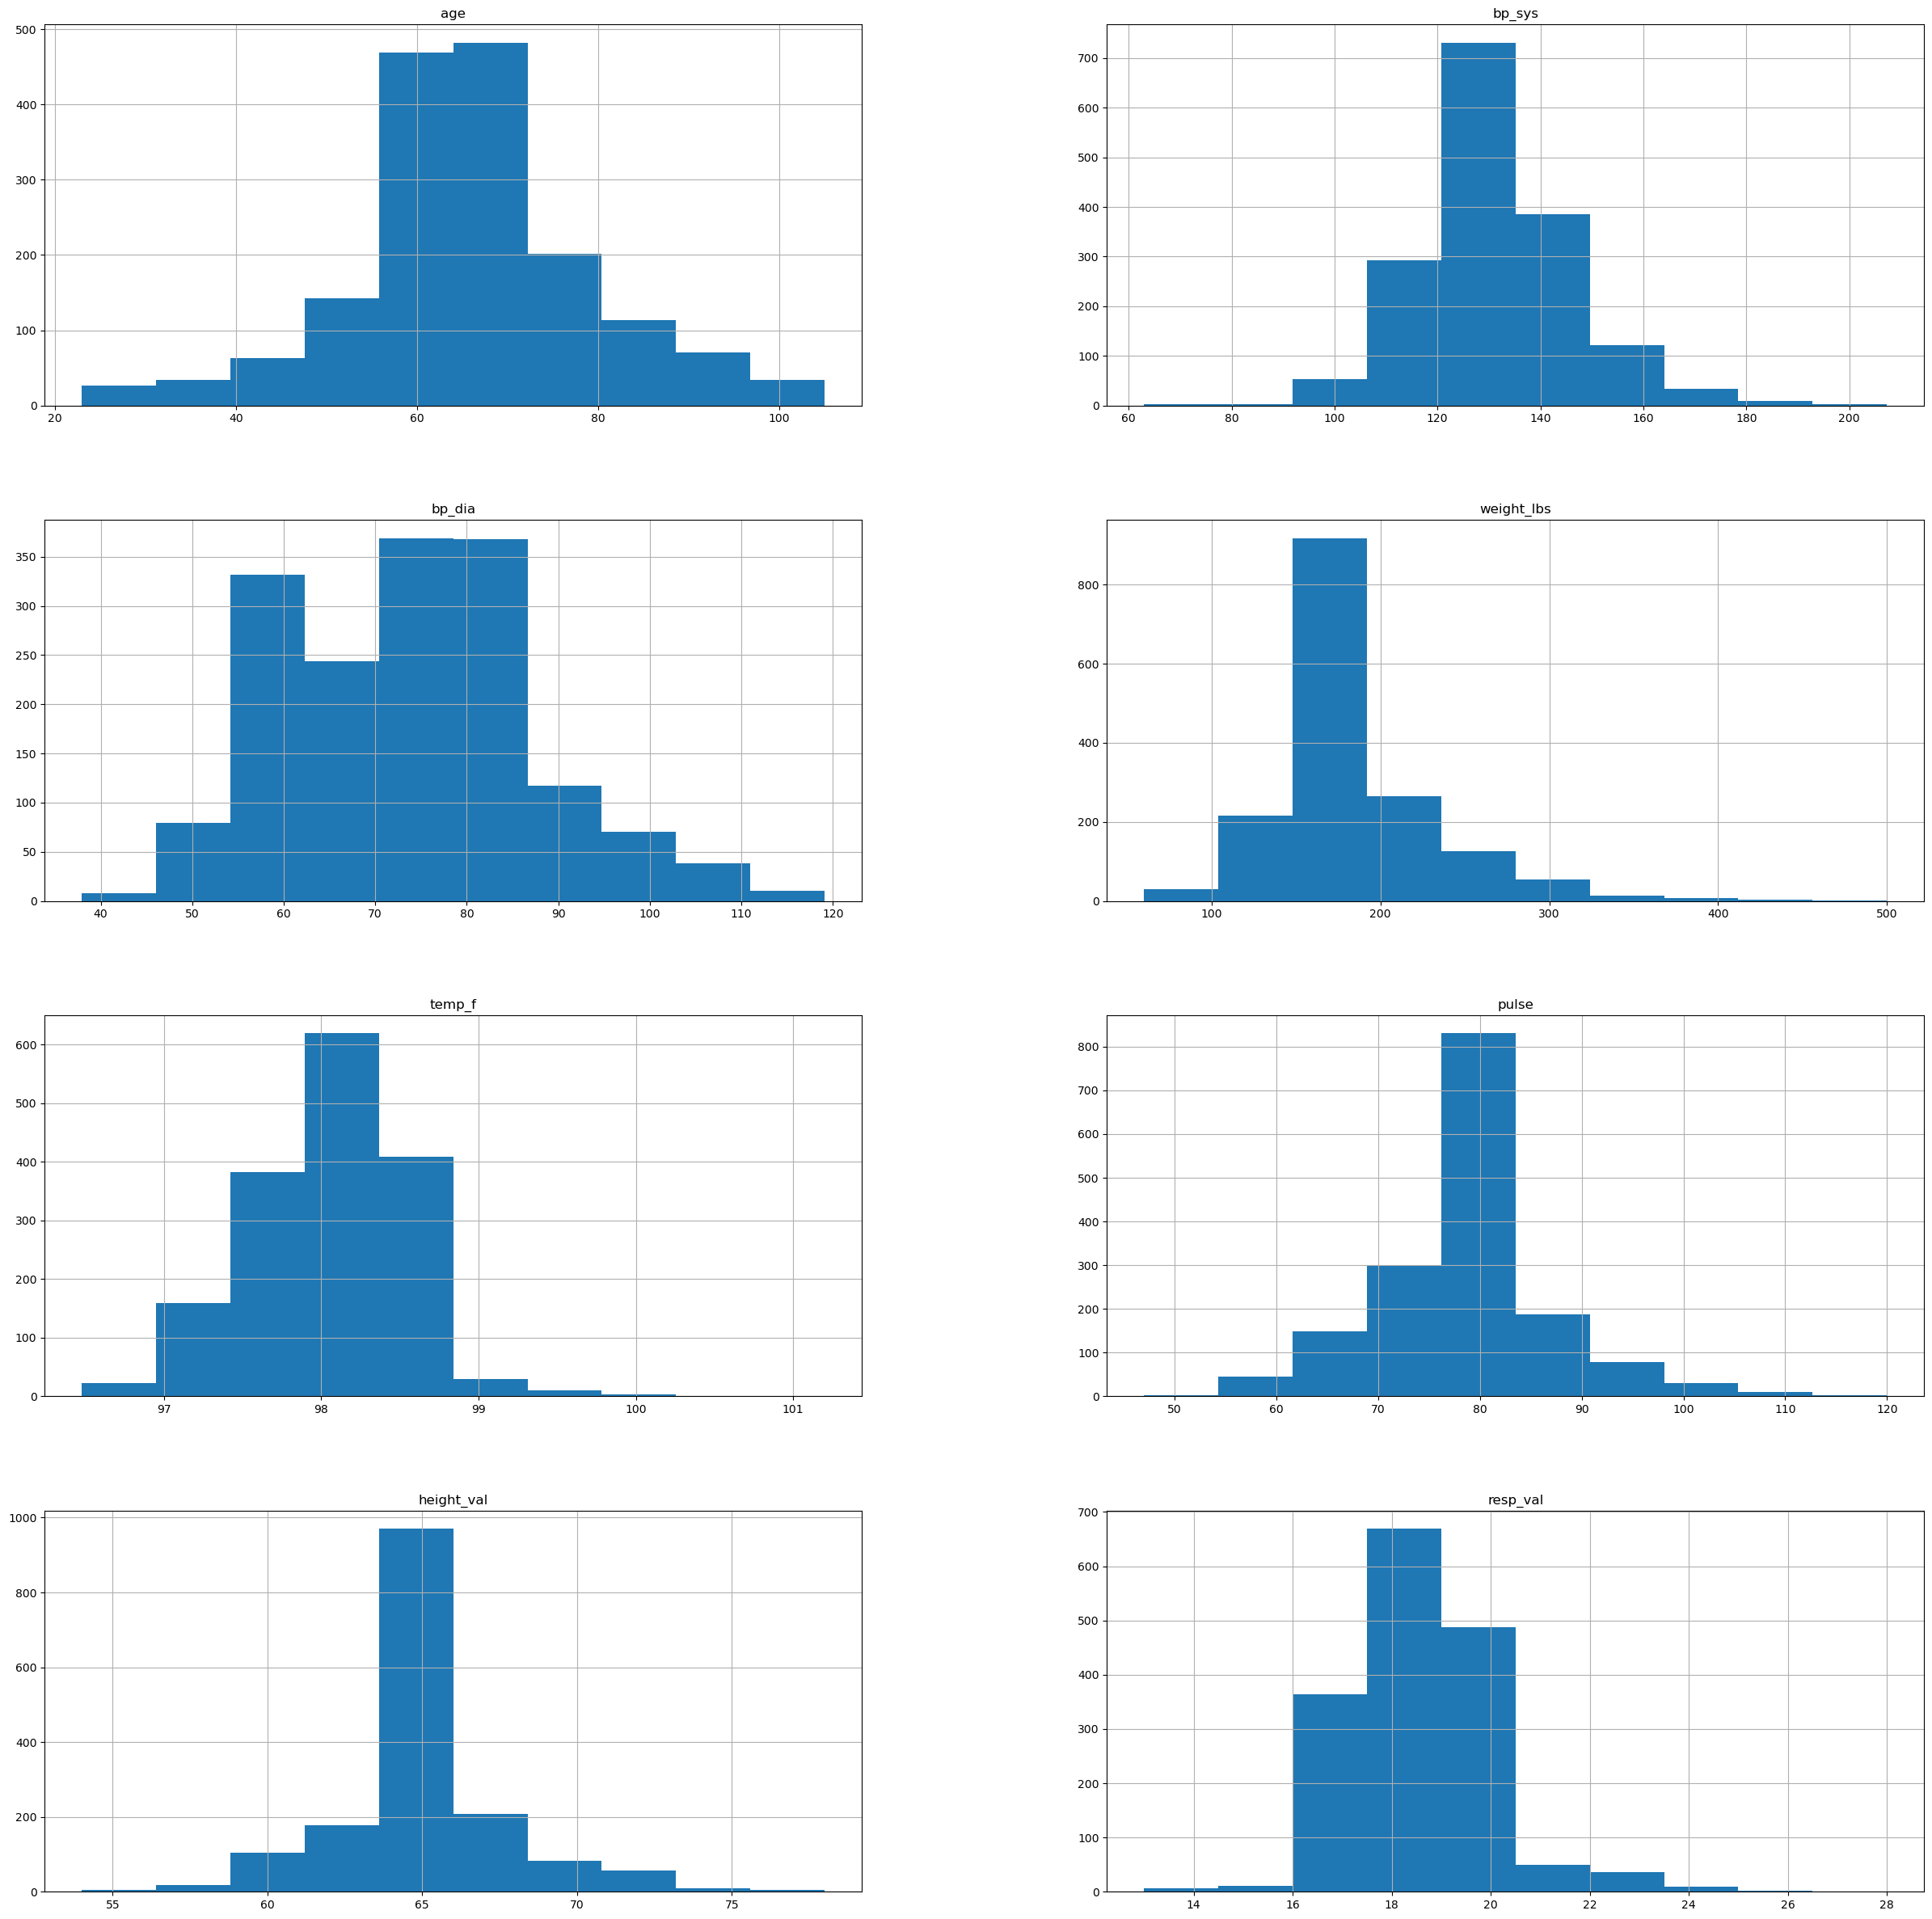

In [10]:
import matplotlib.pyplot as plt 

cols_skew = ['uid', 'age', 'bp_sys', 'bp_dia',
       'weight_lbs', 'temp_f', 'pulse', 'height_val', 'resp_val']

#define format for subplots (1 row and 3 columns)
fig, axis = plt.subplots(4, 2, figsize=(30, 30))


#create histogram for each column in DataFrame
patient_stats_df[cols_skew].drop('uid',axis=1).hist(ax=axis)

From the plots above, at first glance we can see that most health statistics--with the exception of weight lbs--are either fairly symmetrical (skewness is between -0.5 and 0.5) or only moderately skewed (skewness is between -1 and 0.5 or between 0.5 and 1).  We verify below:


In [11]:
patient_stats_df[cols_skew].skew()

age          -0.020241
bp_sys        0.439612
bp_dia        0.315852
weight_lbs    1.497189
temp_f        0.069059
pulse         0.710124
height_val    0.524215
resp_val      0.496593
dtype: float64

We will likely use a tree-based classfier for prediction which are unaffected by skewed distributions.  Nevertheless, we'll log transform weight_lbs to reduce skewness.

## Detect Outliers

Now we would like to detect outliers in our observations.  Once identified, we will determine if we will remove or leave the outliers in our dataset.  We will use [Tukey's method](https://en.wikipedia.org/wiki/Tukey%27s_range_test)  to remove outliers. Outliers are defined as data points above or below 1.5 times the inter-quartile range from the quartiles: below Q1–1.5*IQR or above Q3+1.5*IQR are outliers.

In [12]:
patient_stats_no_outlier_dfs = detect_outliers(patient_stats_df, patient_stats_df.drop('uid', axis=1))

100%|██████████| 1662/1662 [00:00<00:00, 34243.59it/s]

Processed outliers


The patient_stats_no_outliers_df dataframe now contains a set of patients and corresponding health statistics that were not filtered via the outlier detection test.

In [13]:
no_outlier_ids = patient_stats_no_outlier_dfs.uid.unique()

Since we are dealing with a highly imbalanced dataset with much fewer instances of the minority class (hospitalizations) which we'd like to predict relative to the majority class (visits with now hospitalization) we do not want to run the risk of losing valuable information by indiscriminately dropping outliers from our dataset.  So, we'll analyze the impact of dropping those outliers further below.

#### Full Dataset Visits vs. Hospitalizations

The full dataset, without the removal of outliers, is composed of the percentage of hospitalizations shown below.  This shows that we are dealing with an imbalanced dataset, so we'll need to be cautious of removing minority class instances from our dataset.

In [14]:
ttl_visits = len(visits_health_stats_by_week_df)
ttl_hosp = visits_health_stats_by_week_df.hospitalized.sum()
per_hosp = ttl_hosp / ttl_visits 

print('Total visits: ' +f"{ttl_visits:,}") 
print('Total hospitalizations: ' +f"{ttl_hosp:,}") 
print('Percentage of hospitalizations among all visits: ' +"{:.0%}".format(per_hosp))

Total visits: 32,226
Total hospitalizations: 2,889.0
Percentage of hospitalizations among all visits: 9%


#### Outlier Dataset Visits vs. Hospitalizations

The outlier dataset has over twice an nearly three times the rate of hospitalizations per visit as the full patient population.

In [15]:
ttl_visits = len(visits_health_stats_by_week_df[~visits_health_stats_by_week_df.uid.isin(no_outlier_ids)])
ttl_hosp = visits_health_stats_by_week_df[~visits_health_stats_by_week_df.uid.isin(no_outlier_ids)].hospitalized.sum()
per_hosp = ttl_hosp / ttl_visits 

print('Total visits: ' +f"{ttl_visits:,}") 
print('Total hospitalizations: ' +f"{ttl_hosp:,}")
print('Percentage of hospitalizations among all visits: ' +"{:.0%}".format(per_hosp))

Total visits: 6,775
Total hospitalizations: 1,806.0
Percentage of hospitalizations among all visits: 27%


#### Assess Removing Outliers from Dataset

If we were to remove the outlier patients from our dataset, we would reduce our minority class further.

In [16]:
ttl_visits = len(visits_health_stats_by_week_df[visits_health_stats_by_week_df.uid.isin(no_outlier_ids)])
ttl_hosp = visits_health_stats_by_week_df[visits_health_stats_by_week_df.uid.isin(no_outlier_ids)].hospitalized.sum()
per_hosp = ttl_hosp / ttl_visits 

print('Total visits: ' +f"{ttl_visits:,}") 
print('Total hospitalizations: ' +f"{ttl_hosp:,}")
print('Percentage of hospitalizations among all visits: ' +"{:.0%}".format(per_hosp))

Total visits: 25,451
Total hospitalizations: 1,083.0
Percentage of hospitalizations among all visits: 4%


##### Outlier vs. Non-Outlier Patient Groups

When we plot and compare the differences among health stats between outlier and non-outlier patients we can see that--other than weight and pulse--they are nearly identical. (This is unsurprising, since there is a higher rate of hospitalizations for our outlier patients which could also correlate with higher weights and higher pulses--both unfavorable health indicators)

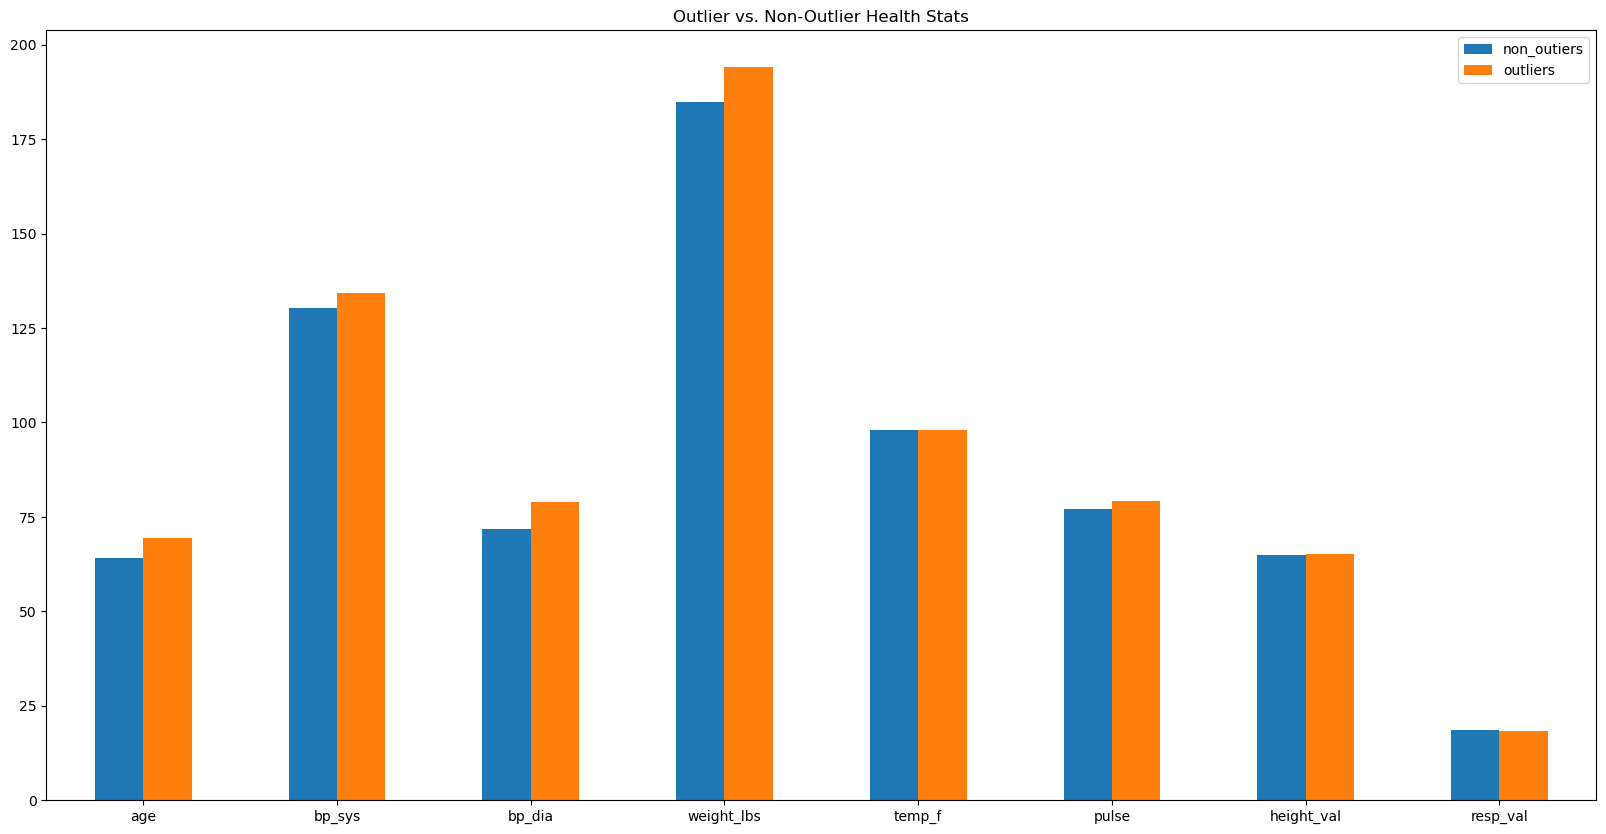

In [17]:
a_df = patient_stats_df[patient_stats_df.uid.isin(no_outlier_ids)].drop('uid',axis=1).mean()
o_df = patient_stats_df[~patient_stats_df.uid.isin(no_outlier_ids)].drop('uid',axis=1).mean()

non_out = a_df.to_list()
out = o_df.to_list()
index = a_df.index
df = pd.DataFrame({'non_outiers': non_out,
                   'outliers': out}, index=index)
ax = df[~df.index.isin(['hosp_per_visit', 'total_score', 'wound_number'])].plot.bar(rot=0,figsize=(20, 10), title='Outlier vs. Non-Outlier Health Stats')


When we look at hospitalizations per visit, we see a major difference for outlier vs non-outlier patients.

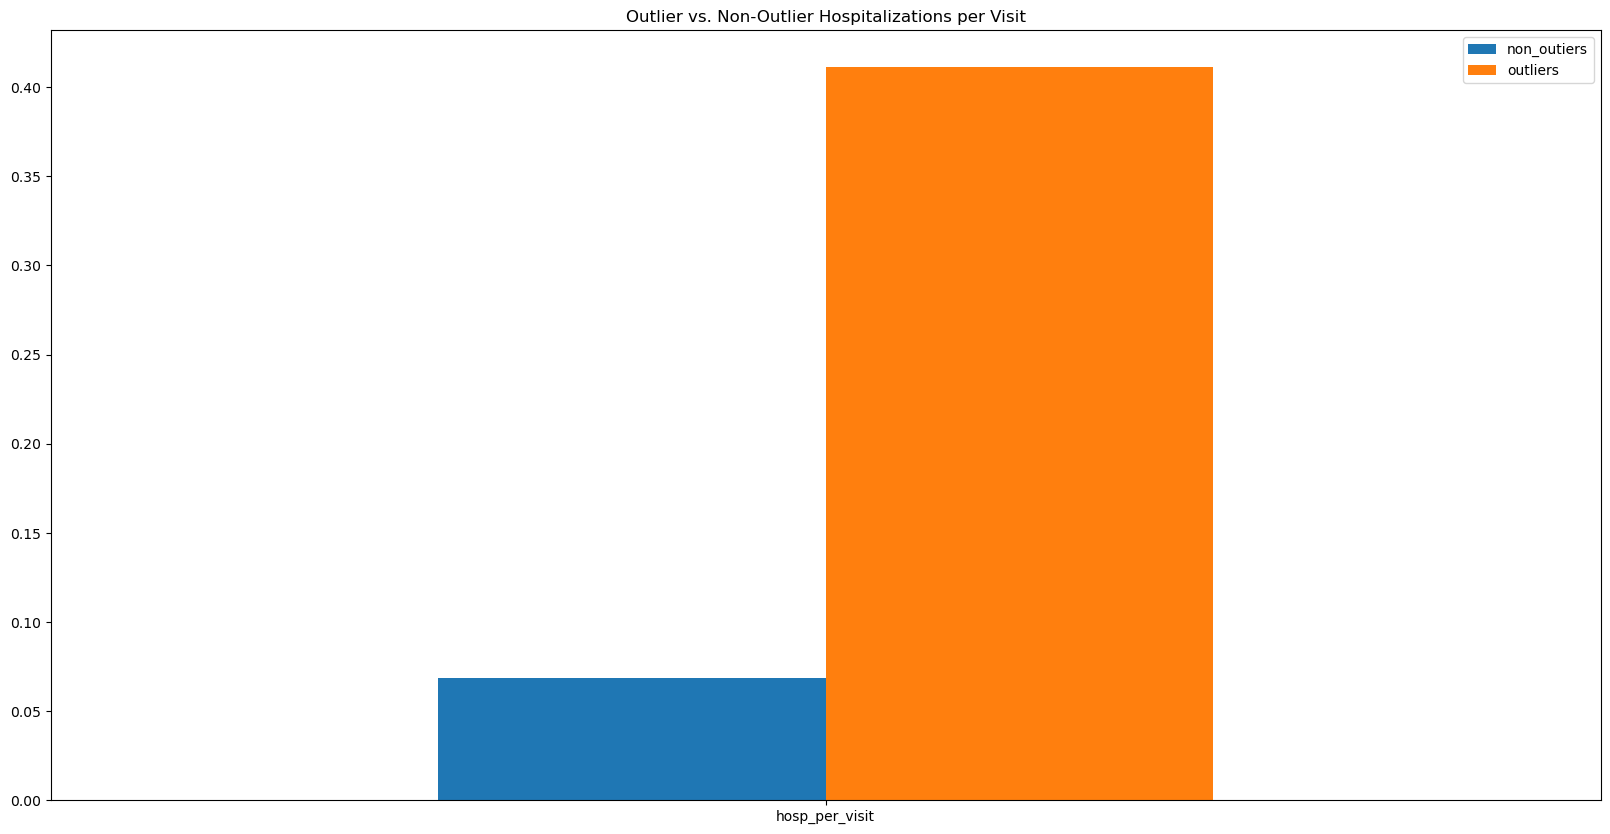

In [18]:
non_out = a_df.to_list()
out = o_df.to_list()
index = a_df.index
df = pd.DataFrame({'non_outiers': non_out,
                   'outliers': out}, index=index)
ax = df[df.index.isin(['hosp_per_visit'])].plot.bar(rot=0,figsize=(20, 10), title='Outlier vs. Non-Outlier Hospitalizations per Visit')

## K-Means Clustering

We will use our previously created summary of patients health statistics to cluster patients using K-Means. 

In [19]:
patient_stats_df = patient_stats_df.replace(np.nan, 0)

Prepare data for K-means by droping uid and scaling.

In [20]:
data = patient_stats_df[['uid', 'age', 'bp_sys','bp_dia', 'hosp_per_visit']].drop('uid', axis=1)
X = StandardScaler().fit_transform(data)

Run K-means

In [21]:
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster center
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

By using the Elbow Method for identifying the optimal number of clusters, k appears to be betweem 3 and 4 but is still unclear.

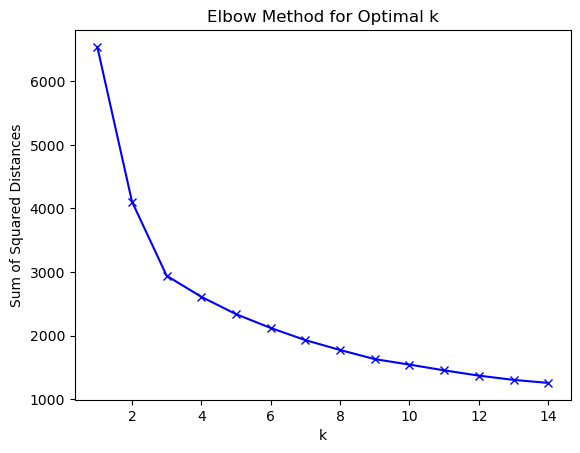

In [22]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

We will be using the Calinski Harabasz scores to hone in optimal k.

In [23]:
kmeans_results_df = pd.DataFrame(columns = ['no_clusters','calinski_harabasz_score', 'y_hat'])

C = range(2,7)
for c in C:
    k_means = KMeans(n_clusters=c)
    model = k_means.fit(X)
    y_hat = k_means.predict(X)

    labels = k_means.labels_
    #sil = metrics.silhouette_score(X, labels, metric = 'euclidean')
    cal = metrics.calinski_harabasz_score(X, labels)

    # append rows to an empty DataFrame
    kmeans_results_df = kmeans_results_df.append({'no_clusters' : c, 'calinski_harabasz_score' : cal, 'y_hat':y_hat},
            ignore_index = True)

In [24]:
kmeans_results_df

,no_clusters,calinski_harabasz_score,y_hat
0,2,967.517082,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,3,998.473579,"[0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, ..."
2,4,818.401586,"[1, 0, 2, 3, 0, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, ..."
3,5,732.401869,"[0, 1, 2, 3, 0, 0, 3, 2, 1, 1, 1, 0, 3, 1, 0, ..."
4,6,677.906279,"[0, 1, 2, 4, 1, 0, 4, 2, 1, 1, 1, 0, 4, 1, 1, ..."


In [25]:
optimal_no_clusters = int(kmeans_results_df[kmeans_results_df.calinski_harabasz_score == kmeans_results_df.calinski_harabasz_score.max()]\
    ['no_clusters'].values[0])
    
print('From our results, the optimal number of clusters should be k = '+str(optimal_no_clusters))

From our results, the optimal number of clusters should be k = 3


We retrieve the results for the optimal number of clusters identified

In [26]:
y_hat_optimal = kmeans_results_df[kmeans_results_df.no_clusters == optimal_no_clusters].y_hat.values[0]

Join cluster results and sort by hospitalizations per visit

In [27]:
c_df = pd.DataFrame(y_hat_optimal, columns = ['cluster'])
clusters_df = patient_stats_df.join(c_df)
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df = clusters_mean_df.sort_values(by='hosp_per_visit', ascending=False)
clusters_mean_df = clusters_mean_df.reset_index()

In [28]:
clusters_mean_df = clusters_mean_df.reset_index().rename(columns={'index':'cluster_new'})

In [29]:
clusters_mean_df

,cluster_new,cluster,age,bp_sys,bp_dia,weight_lbs,temp_f,pulse,height_val,resp_val,hosp_per_visit
0,0,1,82.849315,143.691815,93.713643,186.673399,98.076870,79.652422,65.085017,18.611280,0.920511
1,1,2,67.767596,136.649569,79.303233,189.131814,98.061228,77.526010,64.948043,18.438558,0.049078
2,2,0,57.514329,121.394713,61.035252,185.655112,98.034533,77.415459,65.088029,18.344061,0.040461


In [30]:
clusters_df = clusters_df.merge(clusters_mean_df[['cluster','cluster_new']], left_on='cluster', right_on='cluster').drop('cluster',axis=1).rename(columns={'cluster_new':'cluster'})

In [31]:
clusters_df.groupby('cluster').count()

,uid,age,bp_sys,bp_dia,weight_lbs,temp_f,pulse,height_val,resp_val,hosp_per_visit
cluster,,,,,,,,,,
0,219,219,219,219,219,219,219,219,219,219
1,753,753,753,753,753,753,753,753,753,753
2,663,663,663,663,663,663,663,663,663,663


In [32]:
clusters_df = clusters_df[['uid','cluster', 'hosp_per_visit']]

# Feature Engineering

Listed below are a summary of EDA findings followed by the execution of the feature engineering step EDA informs (if applicable)

1. **Seasonal Decomposition** - Decomposition of our time series dataset uncovered seasonality in our data in terms of hospitalization rates.  Although we observed an overall downward trend for hospitalizations, we will hold off on encoding this feature pending additional data collection.

>**1.1 Action:** Add a seasonal trend feature to our data.

In [33]:
visits_health_stats_by_week_df = visits_health_stats_by_week_df.merge(seasonal_df, left_on='visit_date_month', right_on='month').rename(columns={'seasonal':'seasonal_decomp'})

In [34]:
seasonal_df.to_parquet('data/seasonal_feature.parquet')

4. **Outlier Detection** - We found ~400 patients which were deemed outliers based on their health statistics and the ratio of hospitalizations per total visits.  However, after analyzing further this outliers are simply patients that are hospitalized at a much greater rate than others in the full patient population under analysis.  The decision was made to keep these outliers as they will be critical to maintain within the minority class (i.e., hospitalizations) of our imbalanced dataset.

>**4.1 Action:** No action needed.  We will retain outlier records (i.e., patients)

5. **K-Means Clustering** - We clustered patients based on a health statistics including hospitalization rate.  We found that there were four unique clusters (0-3) with 0 corresponding to those patients with highest hospitalization rates to cluster 3 corresponding to those patients with the lowest hospitalization rate.nbsp

>**Action:** Merge the cluster number identified and stored in the df_clusters dataframe to our master dataset.

In [35]:
visits_health_stats_by_week_df = visits_health_stats_by_week_df.merge(clusters_df, left_on='uid', right_on='uid')

6. **One-Hot Encoding of Remaining Categorical Features** - We have already one-hot encoded medications in order to remove duplication in our health statistics dataset.  Now we will encode remaining categorical variables.

In [36]:
visit_cols = ['uid', 'visit_date_year', 'visit_date_month', 'visit_date_week_no',
       'visit_date_week_dt', 'visit_date', 'ttl_visits', 'ttl_hosp_week', 'ttl_hosp_count',
       'hospitalized']

cat_df = visits_health_stats_by_week_df.drop(columns=visit_cols, axis=1).select_dtypes(include=['object'])
cat_cols = cat_df.columns.to_list()

In [37]:
cat_dum_df = pd.get_dummies(visits_health_stats_by_week_df[cat_cols])
visits_health_stats_by_week_df.drop(columns=cat_cols,axis=1,inplace=True)
cat_dum_df = standardize_column_names(cat_dum_df)

In [38]:
visits_health_stats_by_week_df = visits_health_stats_by_week_df.join(cat_dum_df)

7. **Shift hospitalization history by one week** - For predictions, we will create lag variables that capture cumulative visits and hospitalizations from the previous week.

In [39]:
visits_health_stats_by_week_df['ttl_hosp_prev_week'] = visits_health_stats_by_week_df['ttl_hosp_week'].shift(1)
visits_health_stats_by_week_df['ttl_hosp_prev_week'] = visits_health_stats_by_week_df['ttl_hosp_prev_week'].fillna(0)

visits_health_stats_by_week_df['ttl_hosp_count_prev_week'] = visits_health_stats_by_week_df['ttl_hosp_count'].shift(1)
visits_health_stats_by_week_df['ttl_hosp_count_prev_week'] = visits_health_stats_by_week_df['ttl_hosp_count_prev_week'].fillna(0)

visits_health_stats_by_week_df['ttl_visits_prev_week'] = visits_health_stats_by_week_df['ttl_visits'].shift(1)
visits_health_stats_by_week_df['ttl_visits_prev_week'] = visits_health_stats_by_week_df['ttl_visits_prev_week'].fillna(0)

8. **Add the hospitalizations per visit feature** - Add a feature to encode the ratio of hospitalizations per visit for each patient.

In [40]:
visits_health_stats_by_week_df['hosp_per_visit_prev_week'] = visits_health_stats_by_week_df.ttl_hosp_count_prev_week / visits_health_stats_by_week_df.ttl_visits_prev_week
visits_health_stats_by_week_df['hosp_per_visit_prev_week'] = visits_health_stats_by_week_df['hosp_per_visit_prev_week'].fillna(0)

9. **Remaining Steps** - There are a few remaining steps to prepare the data for prediction.

In [41]:
visits_health_stats_by_week_df = visits_health_stats_by_week_df.drop(columns=['visit_date_year', 'visit_date_month', 'visit_date_week_no',
       'visit_date_week_dt', 'visit_date', 'ttl_visits', 'ttl_hosp_week', 'ttl_hosp_count','hosp_per_visit']) 

# Standardize columns names to follow our convention
visits_health_stats_by_week_df = standardize_column_names(visits_health_stats_by_week_df)

# Encoding the remaining categorical columns caused column duplication. We dedupe columns
visits_health_stats_by_week_df = visits_health_stats_by_week_df.loc[:,~visits_health_stats_by_week_df.columns.duplicated()].copy()

# Replace inf values with zero
visits_health_stats_by_week_df.replace([np.inf, -np.inf], 0, inplace=True)

# Feature Selection

We currently have over 2,000 features that make up part of our feature set.  We'd like to reduce the number of features in our set to reduce overfitting, improve model performance and avoid "curse of dimensionality" among a number of other reasons.  Of the techniques available, we'll go with the [scikit-learm SelectFromModel class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) for this purpose and pass in an estimator.  For this example, we'll go with a Random Forest estimator, but we can experiment with other options as needed. 

In [42]:
# Split into target variable and predictors
X = visits_health_stats_by_week_df.drop(columns =['uid', 'hospitalized'], axis=1)
y = visits_health_stats_by_week_df.hospitalized

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Initialize SelectFromModel using the trained classifier
sfm = SelectFromModel(clf, prefit=True)

# Transform the DataFrame to select the most important features
X_new = sfm.transform(X)

# Create new dataframe with reduced feature set
visits_health_stats_by_week_reduced_df = pd.DataFrame(X_new, columns=X.columns[sfm.get_support()])
visits_health_stats_by_week_reduced_df['hospitalized'] = y

NameError: name 'RandomForestClassifier' is not defined

# Write Dataset for Prediction

We now have a dataset ready to be split into training and test datasets for use in our model.

In [ ]:
visits_health_stats_by_week_reduced_df.to_parquet('data/diagnosis_health_stats_hosp_by_week_pred.parquet')

# Predict

There are a number of issues with the approach taken for predicting hospitalizations below.  One of which is not accounting for the imbalanced dataset, roughly a 10 to 1 ration between the majority class vs. the minority class (1 or hospitalizations).  The other issue is not accounting for the temporal nature of the dataset.  By using the standard train/test split below, we are likely including visits from the future to predict the past--in other words, we are introducing data leakage in the training of our model. We will address both of these issues via our cross-validation technique and by incorporating the class imbalance as one of the parameters passed into our models.

In [ ]:
X = visits_health_stats_by_week_reduced_df.drop(columns =['hospitalized'], axis=1)
y = visits_health_stats_by_week_reduced_df.hospitalized

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the LGBMClassifier
lgb_classifier = lgb.LGBMClassifier(objective='binary', random_state=42)

# Fit the model on the training data
lgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lgb_classifier.predict(X_test)
y_pred_proba = lgb_classifier.predict_proba(X_test)[:, 1]  

# Evaluate the model
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)

print(f"F1: {f1:.2f}")
print(f"Recall: {recall:.2f}")